In [2]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# A Game of Dice: Farkle!
## Rules of Play
The rules of the game vary widely, but we will consider a specific case here. The player starts by rolling six dice. The player sets aside dice that are worth points and rolls the remaining dice. At least one dice must be set aside after each roll. If you can set aside all six dice, then you can roll them all again to continue building up your total. A **Farkle** occurs when there are no combinations of dice that are worth points. In this case, you lose all your points from that turn and your turn is over. You may stop rolling at anytime during your turn, in which case your total gets entered on the score sheet and your turn is over. The first player to 10,000 points is declared the winner and gets bragging rights until the next game. 

There are a couple technical points that don't affect what we will investigate here, but I mention them for completeness. First, to score for the first time, you must score at least 500 points before you stop rolling. This is referred to as 'getting on the board'. Second, once somebody breaks 10,000 points and decides to stop rolling, every other play gets one more turn to try to break that score. If they can do so, then they are declared winner instead.

Different dice combinations are worth various points. Here is a complete list of scoring combinations.

| Dice Combination | Points | Dice Combination | Points
| :- | :- | :- | :- |
| 6 of  a kind | 3,000 | 4 of a kind with a pair | 1,500
| Two triplets | 2,500 | 4 of a kind | 1,000
| 5 of a kind | 2,000 | 3 of a kind (!= 1) | 100$\times$value of dice
| 1-6 straight | 1,500 | Single 1 | 100
| 3 pairs | 1,500 | Single 5 | 50

## Risk Strategy
The universal question of Farkle players: when to stop rolling? Here are a couple limiting cases to illustrate the scope of the question.
- **Limiting Case #1** It's the beginning of your turn and you roll all six dice. You can only set aside a single 5, worth 50 points. You have 5 dice left. What do you do? The obvious choice is to keep rolling. With five dice left, you are likely to accrue more points.
- **Limiting Case #2** You are several rolls into your turn and have accumulated 3,000 points (an impressive sum!). You only have one dice available to roll. Should you roll it and risk a Farkle (thereby flushing your bounty down the drain), or should you call it and take your 3,000 points? The obvous answer is to stop rolling! Speaking from experience, it's not very common to get to 3,000 points, and you are more likely than not to Farkle with only one dice being rolled.

These are the obvious limiting cases, but what about the cases in the middle? Suppose you have 450 points and have 3 dice left to roll, what should you do?

## Hacker Statistics
To answer this question, we will employ a simple strategy. We will simply play the game many times, however we will play it a little bit differently. First, there is only one play in this game. Second, there is only one turn per game. Finally, this player is an addiction addict! They keep rolling, whatever the odds, until they Farkle. The player then jots down what score they had before the Farkle occurred. If the player does this millions of times, then we should get a clear idea of what single turn scores are likely and what single turn scores are unlikely.

## Decision Trees
Before doing this, we have to set some standards for decision making. Different people have different 'strategies' and risk tolerances. Here I lay out how the decisions will be made here. Suppose we just rolled the dice. We start by looking at the most lucrative combinations in the table above and check if this combination is present in our roll. For the first several entries, there is no ambiguity. If you have 6 of a kind, then take it! 

The abmiguity enters in when we are looking at the 3 of a kinds and below. I have met people that, faced with three ones, will prefer to set aside a single one for 100 points and reserve the remaining two dice for future rolls. After each roll, we implement the following strategry:
- Starting from the most lucrative combination in the table above and going down to 3 of a kinds, we check to see if that combination is present in our roll. If so, we take it and set aside the appropriate dice.
- We always take a 3 of a kind if present and there's nothing more lucrative.
- We always take all 1's that are present if there's nothing more lucrative.
- If nothing else is available, but there is at least one 5, then we take exactly one 5. We reserve the remaing dice for future rolls. The exception to this rule is if by taking all fives, we are able to set aside all of the dice and continue rolling with all six. 

In the following cell we define an object that performs this decision tree. I have minimized the cell for overall readability of the notebook, but feel free to expand it and take a look!

In [7]:
class FarkleRoll(object):
    def __init__(self):
        # Current score
        self.score = 0
        self.n_dice = 6
        self.taken = 0
        self.roll = Counter()
        
    def play(self):
        rolling = True
        i=0
        while rolling:
            self.taken=0
            assert self.n_dice > 0, "No dice available"
            self.roll_dice(self.n_dice)
            #print(self.roll)
            self.parse_roll(self.n_dice)
            #print(self.score, self.taken)
            #i+=1
            if self.taken==0:
                rolling=False
                return self.score
            elif self.taken==self.n_dice:
                self.n_dice = 6
            elif self.taken >= 0:
                self.n_dice -= self.taken
                assert self.n_dice >=0, "Can't have {} dice".format(self.n_dice)
        
    def roll_dice(self, n, forced=None):
        """Rolls dice. Generates n_dice number of random integers
        between 1 and 6."""
        if forced==None:
            roll_arr = np.random.randint(1, 7, size=n)
        else:
            roll_arr = forced
        self.roll = Counter(roll_arr)
        
    def parse_roll(self, n_initial):
        """Given a roll of the dice, find max score."""
        n_initial = sum(self.roll.values())
        if sum(self.roll.values())==6:
            self.is_six_of_kind()
        if sum(self.roll.values())==6:
            self.is_two_triplets()
        if sum(self.roll.values())>=5:
            self.is_five_of_kind()
        if sum(self.roll.values())==6:
            self.is_straight_flush()
        if sum(self.roll.values())==6:
            self.is_three_pairs()
        if sum(self.roll.values())>=4:
            self.is_four_of_kind()
        if sum(self.roll.values())>=3:
            self.is_three_of_kind()
        # Always check for ones and fives:
        self.is_100()
        self.is_50()
        
            
    def is_six_of_kind(self):
        """Checks if there's six of a kind. If so, increment
        score by 3000 and remove all dice from table"""
        if max(self.roll.values())==6:
            self.score += 3000
            self.roll.clear()
            self.taken += 6
    
    def is_two_triplets(self):
        """Checks if there's two triplets in roll. If so,
        increment score by 2500 and remove all dice from table."""
        if (len(self.roll.items())==2)&(list(self.roll.values())==[3,3]):
            self.score += 2500
            self.roll.clear()
            self.taken += 6
            
    def is_five_of_kind(self):
        """Checks if there's five of a kind in roll. If so,
        increment score by 2000 and remove five dice from roll."""
        if max(self.roll.values())==5:
            self.score += 2000
            _ = self.roll.pop(self.roll.most_common(1)[0][0])
            self.taken += 5
            
    def is_straight_flush(self):
        """Checks if there's 1-6 straight. If so,
        increment score by 1500 and remove all dice rom table."""
        if len(self.roll.items())==6:
            self.score += 1500
            self.roll.clear()
            self.taken += 6
            
    def is_three_pairs(self):
        """Checks if there's three pairs. If so, increment
        score by 1500 and remove all dice from table."""
        if (len(self.roll.items())==3)&(list(self.roll.values())==[2,2]):
            self.score += 1500
            self.roll.clear()
            self.taken += 6
            
    def is_four_of_kind(self):
        """Checks if there's four of a kind and if remaining
        dice form a pair."""
        if max(self.roll.values())==4:
            if (sum(self.roll.values())==6)&(min(self.roll.values())==2):
                self.score += 1500
                self.roll.clear()
                self.taken += 6
            else:
                self.score += 1000
                _ = self.roll.pop(self.roll.most_common(1)[0][0])
                self.taken += 4
    
    def is_three_of_kind(self):
        """Checks if there's a three of kind. If so, increment
        score by 100 * dice_value and remove three dice."""
        if max(self.roll.values())==3:
            dice_val = self.roll.most_common(1)[0][0]
            _ = self.roll.pop(dice_val)
            self.score += 100*dice_val
            self.taken += 3
        
    def is_100(self):
        """Checks if there's any 100's in the roll. Take all of them.
        Note that at this point in the decision tree, there is at most two 1s."""
        if self.roll[1]>0:
            to_take = min(2, self.roll[1])
            self.score += to_take*100
            self.roll[1] -= to_take
            self.taken += to_take
    
    def is_50(self):
        """Checks if there's any 50's in the roll. Only take one."""
        if self.roll[5]>0:
            if self.roll[5]==sum(self.roll.values()):
                # Take all the fives if it means using up dice
                self.score += 50*self.roll[5]
                self.taken += self.roll[5]
                _ = self.roll.pop(5)
                
            elif self.taken==0:
                # Only take one five otherwise
                self.score += 50
                self.roll[5] -= 1
                self.taken += 1

## Let's play!
We play 100000 games and look at the scores before Farkles occurred. Since we are interested in turn-to-turn decision, we restrict our attention to turns that score less than 1,000 points. This is meant to exclude outliers so we can get a good look at the pertinent data.

In [9]:
scores = []
for i in range(100000):
    #print(i)
    Roll = FarkleRoll()
    scores.append(Roll.play())
    i += 1

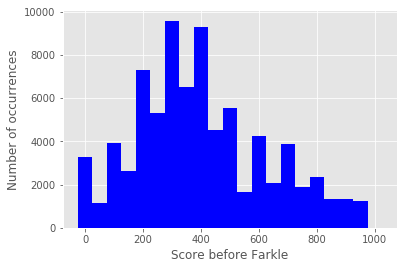

In [10]:
filtered = [x for x in scores if x<1000]

bins = np.arange(0, max(filtered)+150, 50)-25
_ = plt.hist(filtered, bins=bins, color='blue')
_ = plt.xlabel('Score before Farkle')
_ = plt.ylabel('Number of occurrences')

In [17]:
print('Standard deviation of scores = {}'.format(np.std(scores)))

Standard deviation of scores = 654.0798218864422


From the histogram, we see that the most common score is 300, though 400 comes in a very close second! How does this affect your Farkle play? Well, if you are below 300 points on your current turn, it's best to keep rolling. Conversely, if you have 500 points and only one dice left to roll, it's in your better interest to stay where you are!

Will this help you win?! Probably not... The standard deviation of the distribution is ~650, and remember: that's *per turn*. Unless you and your friends decide to play best out of $10^6$ games, random fluctations are likely to determine the winner :(

## The Tails
To conclude this EDA, we zoom out and look at the entire distribution. As one might expect, the distribution of scores falls off exponentially beyond approximatly 400.

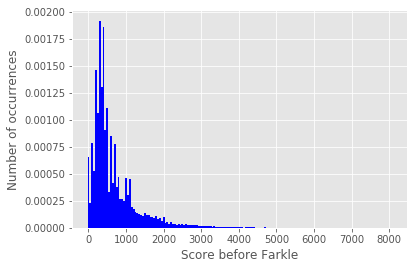

In [15]:
bins = np.arange(0, max(scores)+150, 50)-25
_ = plt.hist(scores, bins=bins, color='blue', density=True)
_ = plt.xlabel('Score before Farkle')
_ = plt.ylabel('Number of occurrences')

## More to Come!
There are a couple direction one could take with this.
1. How do modifications in the decision tree affect the distribution?
2. How many games does one have to play before slight differences in strategy can be resolve?

As always, I'm eager for feedback. If the code can be cleaned up, if there are important items I neglected, or if there are interesting directions of inquiry that I passed by, let me know!